In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [14]:
from metagov import cryptopolitics
from metagov.cryptopolitics import SAVEDIR, QUESTIONS, COLS_QUESTIONS, COLS_RESULTS, q2n, n2q

In [15]:
SAVEFIG = False
fig_ext = '.png'
fig_kwargs = cryptopolitics.KWARGS_PNG

# Cryptopolitical Typology Quiz analysis - dimensionality reduction, factor analysis, and clustering

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Survey results were collected from September 27, 2021 through March 4, 2022 and have been published on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). 

In [16]:
data = cryptopolitics.load_data()
df_questions, df_results = data.values()

id
3462                          [AVAX]
2024                      [Ethereum]
2135                      [Ethereum]
3389             [Bitcoin, Ethereum]
449                       [Ethereum]
                    ...             
795     [Ethereum, Solana, Polkadot]
2904      [Bitcoin, Ethereum, Terra]
1739                      [Ethereum]
2067     [Bitcoin, Ethereum, Solana]
3321                      [Ethereum]
Name: Q19, Length: 3710, dtype: object


## Feature selection, dimensionality reduction, and clustering
We built the initial set of factions by hand, but we were curious whether other factions and features might arise naturally from the data. To look for these, we used clustering methods (e.g. affinity propagation, agglomerative clustering) and feature selection methods (e.g. PCA, feature agglomeration). The hope was to identify and describe clusters of responses (or groupings of questions) in a meaningful way.

While the results are currently inconclusive (no clearly meaningful clusters), we include them here for reference. Let us know if you have questions or suggestions!

Steps involved:
- **Preprocessing** (how to encode the data)
- **Feature selection** (to find which questions most explain variance between respondents) and **dimensionality reduction** (to visualize the clusters; could also be a preprocessing step), i.e., grouping the questions by the responses
- **Clustering** (to find groups of similar respondents), i.e., grouping the responses by the questions

General process notes:
- For many clustering methods, the **distance** or **affinity** metric chosen greatly affects the resulting fit. Since ultimately this data is categorical, wherever there was the option, "manhattan" (cityblock) distance was chosen.

### Preprocessing
- Drop questions relating to specific ecosystems (Q2, Q19)
- Drop rows with any unanswered questions
- **Encode the data** in two ways:
    - **Categorical**: All questions one-hot encoded (49 columns)
    - **Mixed**: All but four categorical questions mapped to ordinal values on -1 to 1 scale, with the remaining questions one-hot encoded (29 columns). The one-hot encoded values are rescaled to reduce their weight relative to the ordinal encoded questions, since each question was split up into four features. *Warning*: this ordinal mapping, done subjectively, greatly affects subsequent results! See the .csv file for the mapping definition.

In [17]:
# Preprocessing
df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19'])
df_to_cluster = df_tmp.dropna()
COLS_QUESTIONS_clustering = COLS_QUESTIONS.copy()
COLS_QUESTIONS_clustering.remove('Q2')
COLS_QUESTIONS_clustering.remove('Q19')

In [18]:
# Import ordinal mapping from file
df_map = pd.read_csv('data/cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        try:
            m = float(row['Mapping'])
        except ValueError:
            m = row['Mapping']
        questionDict[row['Answer']] = m
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2q(k): v for (k, v) in mappingDict.items()}

# Get mapped version of full response DataFrame
df_mapped = df_to_cluster.copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])

print("Mixed ordinal and categorical encoding of the data:")
df_mapped.head()

Mixed ordinal and categorical encoding of the data:


,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
id,,,,,,,,,,,,,,,,,
3462,1.0,-1.0,D,0.333,1.0,0.0,1.0,D,1.0,-1.0,1.0,1.0,-0.333,-1.0,C,C,-1.0
2024,-1.0,-1.0,C,0.333,-1.0,1.0,-1.0,C,1.0,1.0,1.0,1.0,0.333,-1.0,B,C,0.0
2135,-1.0,1.0,B,1.000,1.0,1.0,-1.0,C,1.0,1.0,-1.0,-1.0,-1.000,-1.0,D,D,1.0
449,1.0,-1.0,B,0.333,1.0,1.0,-1.0,A,1.0,-1.0,-1.0,-1.0,-1.000,1.0,B,A,0.0
717,1.0,-1.0,C,1.000,1.0,1.0,-1.0,C,1.0,-1.0,1.0,-1.0,-1.000,-1.0,C,C,0.0


#### Categorical encoding (one-hot)

In [19]:
# Encode categorical questions as one-hot
v = DictVectorizer(sparse=False)
cols_categorical = [n2q(x) for x in [4,9,16,17]]
X_categorical = v.fit_transform(df_mapped[cols_categorical].to_dict(orient='records'))
df_categorical = pd.DataFrame(X_categorical, columns=v.get_feature_names_out())

# Rescale one-hot columns
# This must be set manually based on the coded values!
scaleBy = 0.5 # ordinal_range*(1/n_possible_responses) = (1-(-1))*(1/4); assumes both are constant across questions
df_categorical = df_categorical.multiply(scaleBy) 

# Merge with ordinal to create mixed ordinal-categorical data
df_ordinal = df_mapped.drop(columns=cols_categorical)
df_mixed = pd.concat([df_ordinal.reset_index(drop=True), df_categorical], axis=1)
X_mixed = df_mixed.to_numpy()

df_mixed.shape

(3418, 29)

#### Mixed encoding (ordinal and categorical)

In [20]:
# Encode all questions as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())

df_allCat.shape

(3418, 48)

### Feature selection and dimensionality reduction
 
Here, we might hope to find axes that correspond to something like the "politics" or "economics" axes defined in the survey, or some other belief/value axis not yet identified. These would allow us to view (and even cluster) the data as projected onto these axes.
    
- **PCA (principal component analysis)** (mixed encoding only)
- **Feature agglomeration**

An alternative method that could be relevant here is multiple correspondence analysis.

In [21]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    color = cryptopolitics.DEFAULT_COLOR
    if colors is not None:
        color = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], color=color)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

#### PCA
Besides providing a set of axes on which to project the data for visualization, the first few PCA components could help us understand which questions are most important in explaining variance between respondents. An important caveat: since PCA assumes numerical data, the component values do not correspond exactly to possible encoded answer values. By snapping these values to the nearest possible answer, we can get an approximation of this.

In [22]:
def compute_and_plot_pca(X, N, labels=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)

    print(f"Total variance explained by {N} components: {100*sum(pca.explained_variance_ratio_):.1f}%")    
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.8, figsize=(12,6))
    plt.ylabel('Component value\n(note: scale for ordinal is different from that of categorical)')

    # Print "nearest possible" response value for the first three PCA components
    df_tmp2 = (snap_to_nearest_value(df_tmp.transpose())).transpose()
    print(f"Questions for which the components had different nearest-possible responses:\n\t",
      ", ".join(cryptopolitics.columns_where_rows_differ(df_tmp2.transpose())))
    
    if SAVEFIG:
        # Save original and closest-possible-response versions of results for interpretation
        df_tmp.to_csv(f"{SAVEDIR}/cryptopolitics_pca.csv")
        df_tmp2.to_csv(f"{SAVEDIR}/cryptopolitics_pca_snapto.csv")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_,
             'o-', linewidth=2, color=cryptopolitics.DEFAULT_COLOR)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    # Plot
    scatter_plot_combos(X_transformed, min(N, 3), title='PCA')

    return X_transformed, pca

In [23]:
def snap_to_nearest_value(df):
    """For use with PCA or other vectors that do not correspond exactly to possible answer values.
    
    This is used to help understand which specific questions/responses may play the largest role
    in explaining variance between respondents"""
    
    TOL = 0.85 # How close is "close enough" to a possible response? 0 = exact match.
    MAX_VAL = 0.5 # Assuming Really should 
    
    df_snapto = df.copy()
    for i, row in df.iterrows():
        for col in df.columns:
            qnum = col
            if '=' in col:
                qnum, _ = col.split('=')
            val = row[col]
                
            valsList = sorted(mappingDict[qnum].values())

            if '=' not in col:
                # Method for ordinal values
                valsSpan = valsList[-1] - valsList[0]
                nVals = len(valsList)
                nearestVals = [x for x in valsList if abs(x - val) < TOL*((valsSpan/2)/(nVals-1))]
                if len(nearestVals) == 0:
                    snap_to = np.nan
                else:
                    snap_to = nearestVals[0]
                    if len(nearestVals) > 1:
                        print(f"col {col} has more than one nearest value, i.e., fix your formula!")
            else:
                # Method for categorical values
                if abs(MAX_VAL - val) < TOL*MAX_VAL/2:
                    snap_to = MAX_VAL
                else:
                    snap_to = 0
            
            df_snapto.at[i, col] = snap_to
            
    return df_snapto

Total variance explained by 17 components: 97.8%
Questions for which the components had different nearest-possible responses:
	 Q3, Q5, Q6, Q8, Q14, Q15


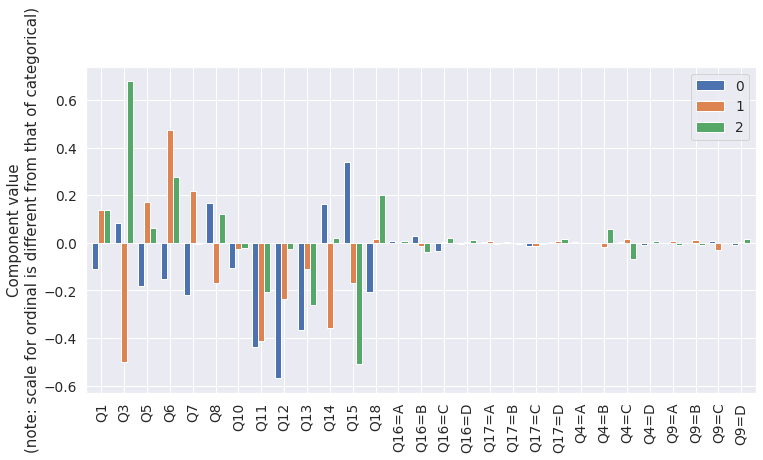

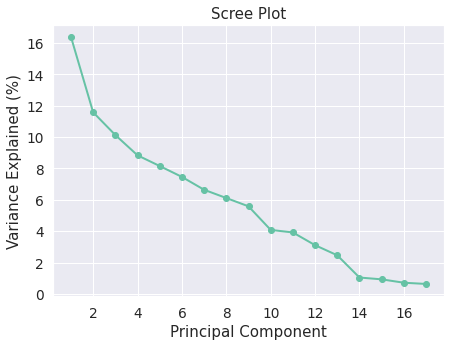

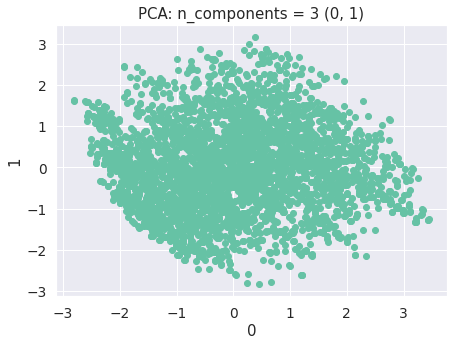

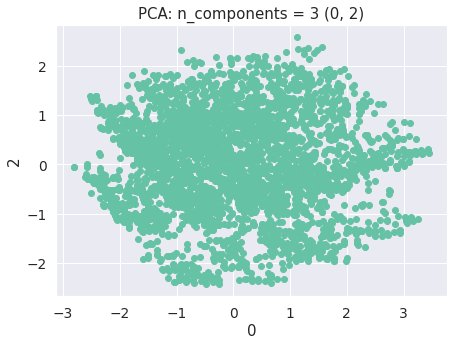

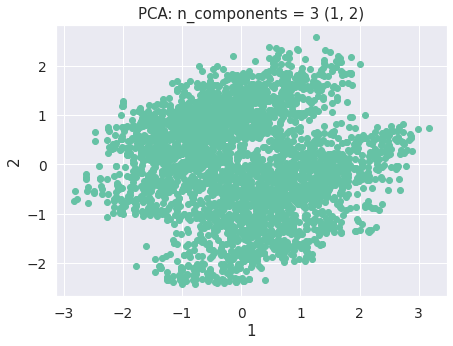

In [24]:
# PCA on mostly-ordinal data (not really meaningful for one-hot-encoded data)
# Display only first three components for convenience. Later on in the notebook, 
# any subset of these components can be selected.

n_PCA = 17 # Number of questions included in this analysis
X_pca, pca_result = compute_and_plot_pca(X_mixed, n_PCA, labels=list(df_mixed.columns))

Based on the PCA component values, Q3, Q5, Q14 (government regulation), Q15 (gender) may play the greatest role in differentiating respondents. However, the variance explained by the first 2-3 components is fairly low (less than 50%), so these results are pretty weak.

Even so, we'll use these components to visualize the clustering later.

#### Feature agglomeration

In [25]:
def compute_and_plot_feature_agglomeration(X, N, labels=None, kwargs={}):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(gb.get_group(key), "\n\n")
    
    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Feature Agglomeration ({kwargs})')

    return X_transformed, fa

In [26]:
kwargs_fa_allCat = {'affinity': 'manhattan', 'linkage': 'complete'}
kwargs_fa_mixed = {'affinity': 'manhattan', 'linkage': 'complete'}#{'affinity': 'cosine', 'linkage': 'single'}

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
3   Q11=Most crypto teams make a fair and reasonab...        0
4   Q12=The economic system in crypto is generally...        0
7   Q13=Most people who want to get ahead in crypt...        0
11  Q14=Work hand-in-hand with regulators to ident...        0
12         Q15=Crypto does not have a gender problem.        0
21                                       Q17=the tech        0
24                                        Q18=Neither        0
25                Q1=There is no one best blockchain.        0
28        Q3=Crypto is mainly an economic technology.        0
37  Q6=Privacy is nice, but it’s not the most impo...        0
39  Q7=Government regulation of crypto can do some...        0
42  Q8=Having a central bank run a cryptocurrency ...        0
45  Q9=Build useful tech that solve real problems ...        0 


                                             questio

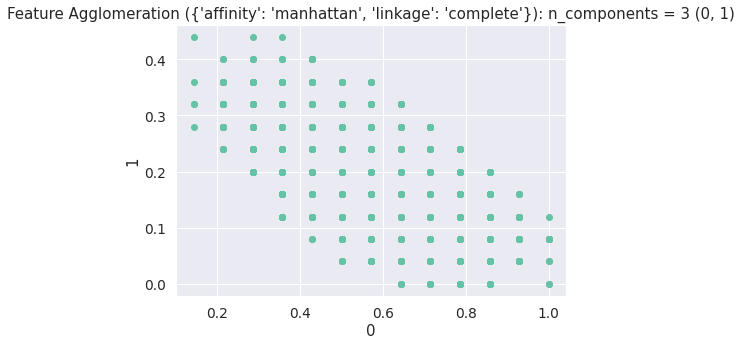

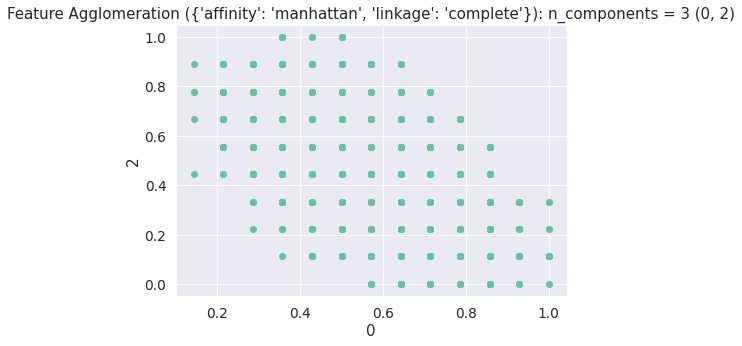

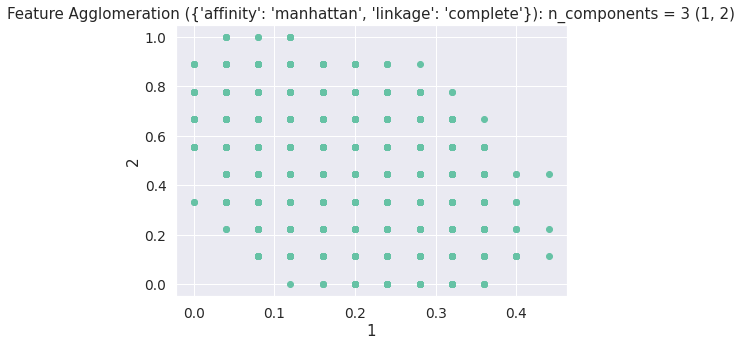

In [27]:
# Feature agglomeration on categorical data - 4 features
X_fa_allCat, fa_result_allCat = compute_and_plot_feature_agglomeration(X_allCat, 3,
                                                                       labels=df_allCat.columns,
                                                                       kwargs=kwargs_fa_allCat)

The features grouped with this method could have some relation to the politics/economics/governance question groups we defined for the faction assignments. Next time around, could programmatically compare the two sets of groupings. 

   question  feature
1        Q3        0
2        Q5        0
4        Q7        0
6       Q10        0
7       Q11        0
8       Q12        0
9       Q13        0
10      Q14        0
12      Q18        0
13    Q16=A        0
14    Q16=B        0
15    Q16=C        0
16    Q16=D        0
17    Q17=A        0
18    Q17=B        0
19    Q17=C        0
20    Q17=D        0
21     Q4=A        0
22     Q4=B        0
23     Q4=C        0
24     Q4=D        0
25     Q9=A        0
26     Q9=B        0
27     Q9=C        0
28     Q9=D        0 


   question  feature
0        Q1        1
3        Q6        1
5        Q8        1
11      Q15        1 




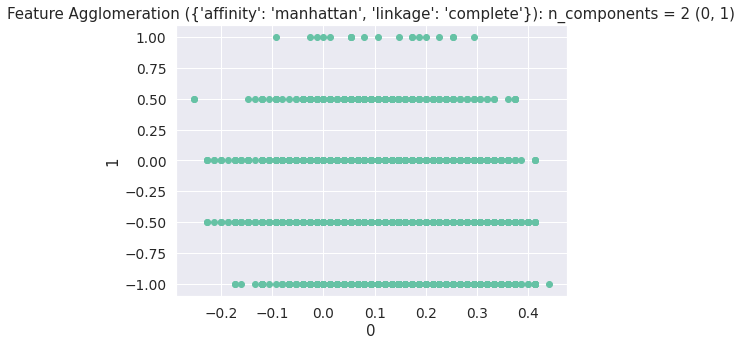

In [28]:
# Feature agglomeration on mixed data - 2 features
X_fa_mixed, fa_result_mixed = compute_and_plot_feature_agglomeration(X_mixed, 2, 
                                                                     labels=df_mixed.columns,
                                                                     kwargs=kwargs_fa_mixed)

The features grouped with this method could also have some relation to the politics/economics/governance question groups we defined for the faction assignments. A quick glance through our own mapping shows that the questions we indicated as related to the economics were all labeled as Feature 1, though the politics and governance questions were scattered across the two features.

We'll use these two sets of results to visualize the clustering later.

### Clustering/group responses by questions
Some methods allow a choice of how many clusters to find. If the clusters correspond to anything like the defined factions, there may be ~4 clusters for ~2 orthgonal "sentiment" axes --> 16 total clusters (e.g., compare w/politics-economics cross-tabulation), but of very different sizes. 
  
- **K-means**: The imposed constraint of equal cluster sizes may not be suitable for this data. However, K-modes clusters corresponding to a representative set of answers is nice.
- **Affinity propagagion**: Has the benefit of interpretability of "exemplar" sample, doesn't impose equal cluster sizes, and doesn't require a choice of clusters. 
- **Agglomerative clustering**: Starts with individual responses and agglomerates responses hierarchically by "distance". This could help identify subgroups within larger schools of thought. 

In [29]:
# In case a lot of clusters are found
COLORS = np.array(sns.color_palette('bright').as_hex() + \
                  sns.color_palette('pastel').as_hex() + \
                  sns.color_palette('dark').as_hex() + \
                  sns.color_palette('muted').as_hex())

#### K-means (really, K-modes and K-Prototypes)
Since this data is categorical/ordinal rather than numerical, we have two alternatives to regular K-means: 
1. Categorical: [K-modes](https://pypi.org/project/kmodes/) clustering
2. Mixed: K-prototypes clustering

In [30]:
def k_clustering_sweep(responseMatrix, kMax=20, method=KModes, kwargs={}):
    """Find clusters using method (KModes or KPrototype)
    Sweep from k=1 to k=kMax and plot resulting cost to evaluate which k may be most useful"""
    
    costMatrix = []
    kValues = list(np.arange(1, kMax+1))
    clusterCentroids = {}
    for k in range(1, kMax+1):
        # Fit and predict clusters, then save centroids and cost
        clusters = method(n_clusters=k, n_init=20)
        clusters.fit_predict(responseMatrix, **kwargs)
        costMatrix.append(clusters.cost_)
        clusterCentroids[k] = clusters.cluster_centroids_
    
    # Plot result of sweep
    plt.plot(kValues, np.divide(costMatrix, max(costMatrix)), color=cryptopolitics.DEFAULT_COLOR)
    plt.xlabel("k")
    plt.ylabel("cost")
    
    return clusterCentroids

##### Categorical

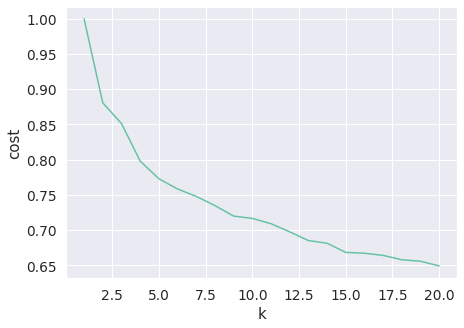

In [31]:
clusterCentroids = k_clustering_sweep(df_to_cluster.to_numpy())

Looks like we've got a bit of an elbow at two clusters, so let's see what the results look like for two clusters:

In [32]:
df_clusters = pd.DataFrame(clusterCentroids[2])
df_clusters.rename(columns={i: x for (i, x) in enumerate(COLS_QUESTIONS_clustering)}, inplace=True)
df_clusters

,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither
1,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to make as much money as ...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,"In crypto, hard work and determination are no ...","Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Liberal or left-wing


In [33]:
print(f"Questions for which the clusters had different mode responses:\n\t",
      ", ".join(cryptopolitics.columns_where_rows_differ(df_clusters)))

Questions for which the clusters had different mode responses:
	 Q3, Q4, Q5, Q6, Q7, Q11, Q12, Q13, Q14, Q16, Q18


#### Affinity propagation

In [36]:
def run_affinity_propagation(X, kwargs={}, X_for_plotting=None, affinity=None):
    """Perform affinity propagation clustering using precomputed affinity"""
    
    if affinity is None:
        # Use default affinity (Euclidean)
        ap = AffinityPropagation()
        ap = ap.fit(X)
        clusters = ap.cluster_centers_
    else:
        # Compute affinities based on given distance metric
        assert affinity in ['manhattan', 'cosine'], "Choose one of 'manhattan' or 'cosine' affinity"
        
        ap = AffinityPropagation(affinity='precomputed')
        
        if affinity == 'manhattan':        
            X_distance = manhattan_distances(X)
            X_affinity = np.exp(-X_distance * (1/X.shape[1]))
        elif affinity == 'cosine':
            X_affinity = cosine_similarity(X)
            
        ap = ap.fit(X_affinity)  
        clusters = X[ap.cluster_centers_indices_]
    
    # Display info on clusters
    print(f"\tn_clusters: {len(clusters)}")
    pointCounts = np.bincount(ap.labels_)
    print(f"\tpoints per cluster: min = {min(pointCounts)}, max = {max(pointCounts)}, median = {int(np.median(pointCounts))}")

    # Plot on appropriate number of projected views (using provided projection, if any)
    colors =  np.array(list(islice(cycle(COLORS),int(len(clusters) + 1))))
    if X.shape[1] <= 3:
        scatter_plot_combos(X, X.shape[1], colors=colors[ap.labels_])
    elif X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=colors[ap.labels_])
        
    return clusters, ap

##### Cluster original one-hot or ordinal encoded data

In [37]:
ap_affinity = 'manhattan' # Use this for both one-hot and ordinal encoded data. Another viable option could be "cosine"

Categorical:
	n_clusters: 291
	points per cluster: min = 2, max = 32, median = 11
Mixed:
	n_clusters: 288
	points per cluster: min = 3, max = 25, median = 12


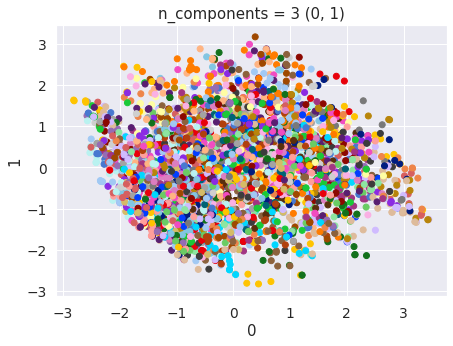

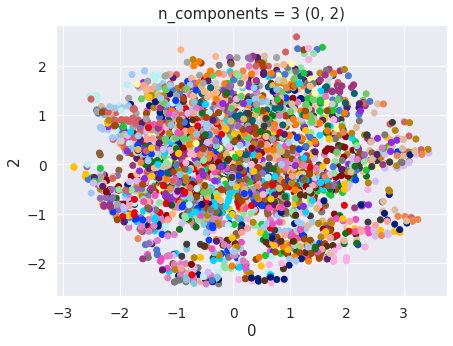

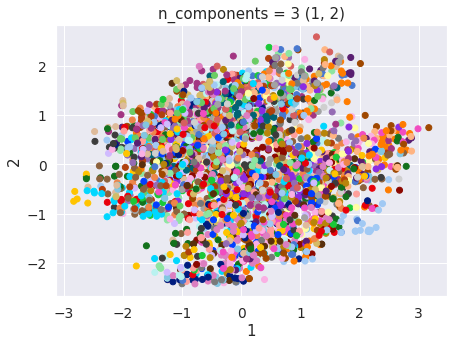

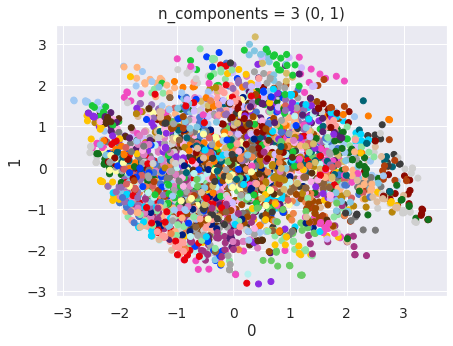

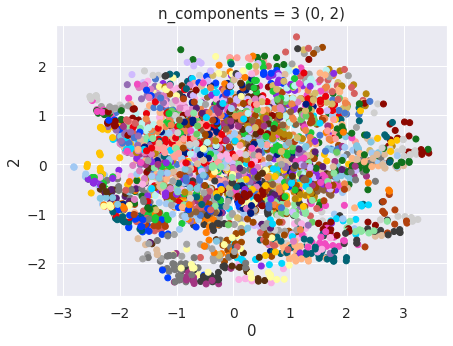

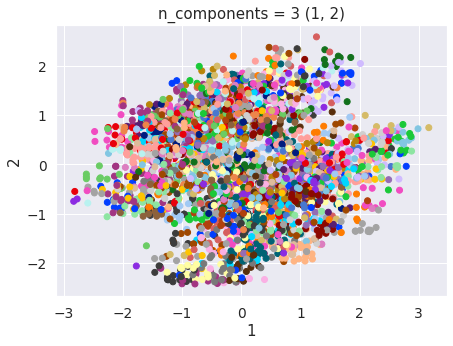

In [38]:
print("Categorical:")
clusters_ap_allCat, ap_allCat = run_affinity_propagation(X_allCat, X_for_plotting=X_pca, affinity=ap_affinity)
print("Mixed:")
clusters_ap_mixed, ap_mixed = run_affinity_propagation(X_mixed, X_for_plotting=X_pca, affinity=ap_affinity)

This is way too many clusters to draw any meaningful conclusions from. But... what if we cluster the clusters themselves? Do the exemplar points consolidate into distinct groupings?

Clustering on cluster centers... PCA projection
Categorical:
	n_clusters: 35
	points per cluster: min = 1, max = 16, median = 7
Mixed:
	n_clusters: 35
	points per cluster: min = 2, max = 17, median = 8


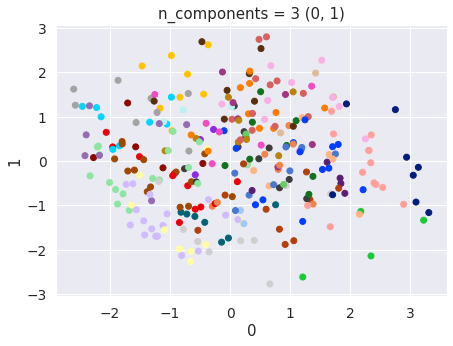

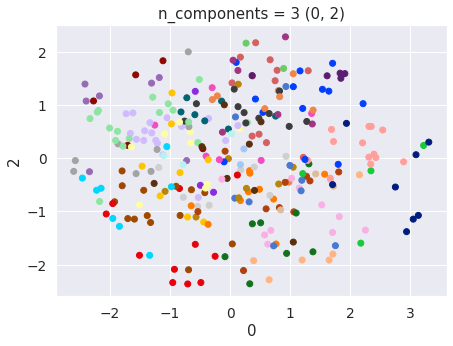

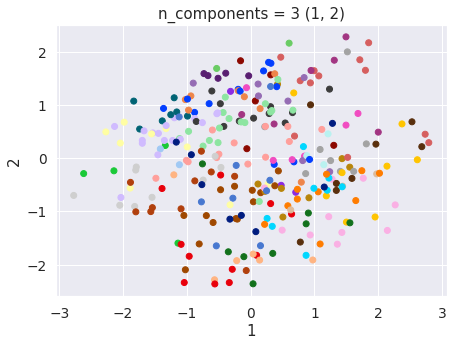

In [39]:
print("Clustering on cluster centers... PCA projection")
print("Categorical:")
clusters_meta_allCat, ap_meta_allCat = run_affinity_propagation(clusters_ap_allCat, affinity=ap_affinity)
print("Mixed:")
clusters_meta_mixed, ap_meta_mixed = run_affinity_propagation(clusters_ap_mixed,
                             X_for_plotting=pca_result.transform(clusters_ap_mixed),
                             affinity=ap_affinity)

Maybe... there is a lot of overlap between clusters though, at least on this projection. 

Clustering on cluster centers... FA projection
Categorical:
	n_clusters: 35
	points per cluster: min = 1, max = 16, median = 7
Mixed:
	n_clusters: 35
	points per cluster: min = 2, max = 18, median = 8


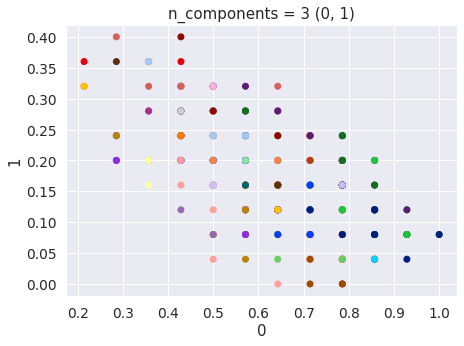

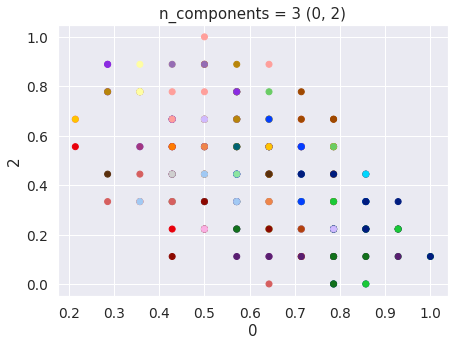

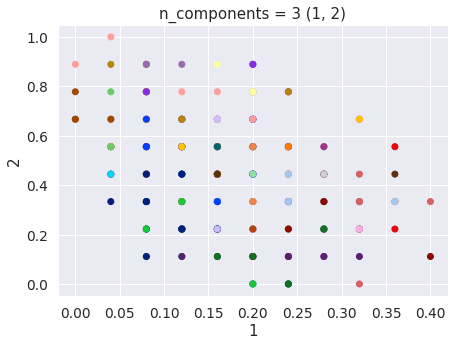

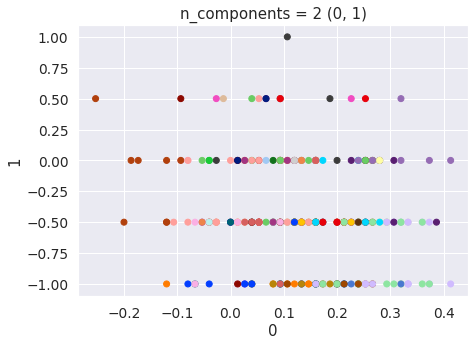

In [40]:
print("Clustering on cluster centers... FA projection")
print("Categorical:")
clusters_meta_allCat, ap_meta_allCat = run_affinity_propagation(clusters_ap_allCat, 
                                                                X_for_plotting=fa_result_allCat.transform(clusters_ap_allCat),
                                                                affinity=ap_affinity)
print("Mixed:")
clusters_meta_mixed, ap_meta_mixed = run_affinity_propagation(clusters_ap_mixed,
                             X_for_plotting=fa_result_mixed.transform(clusters_ap_mixed),
                             affinity=ap_affinity)

Changing the projection doesn't yield anything more insightful.

#### Agglomerative clustering

In [41]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Copied from scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [42]:
def run_agglomerative_clustering(X, nClusters, kwargs={}, X_for_plotting=None):
    """Run agglomerative clustering"""
    
    ac = AgglomerativeClustering(compute_distances=True,
                                 n_clusters=nClusters,
                                 **kwargs)
    ac = ac.fit(X)
    y_predicted = ac.labels_.astype(int)

    # Display info on clusters
    print("number of points in each cluster: ", ", ".join([f"{i}: {str(x)}" for i, x in enumerate(np.bincount(ac.labels_))]))

    # Plot dendrogram of connections between clusters
    plt.figure()
    plot_dendrogram(ac, truncate_mode="lastp", p=nClusters) 

    # Plot on appropriate number of projected views (using provided projection, if any)
    if X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=COLORS[y_predicted])
    else:
        scatter_plot_combos(X, min(X.shape[1], 3), colors=COLORS[y_predicted])

In [43]:
nClusters = 4 # Chosen for the number of (non-NPC-type) factions/classes in each dimension

number of points in each cluster:  0: 1150, 1: 674, 2: 1109, 3: 485
Mixed:
number of points in each cluster:  0: 1139, 1: 752, 2: 1146, 3: 381


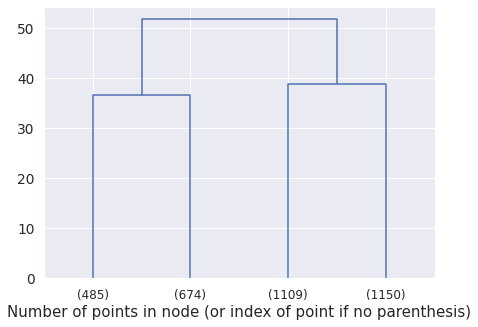

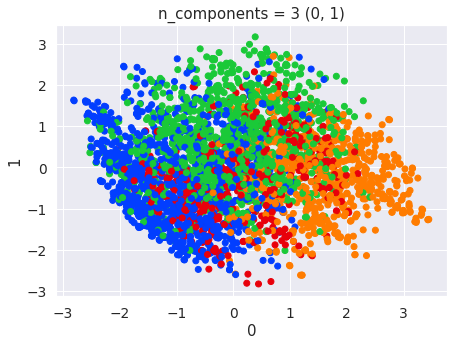

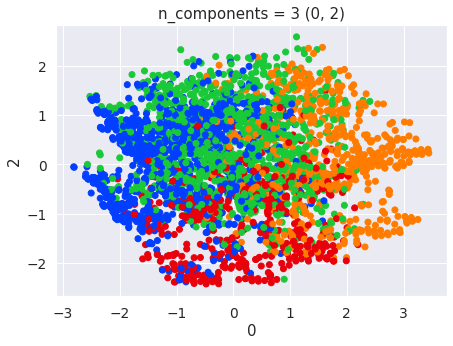

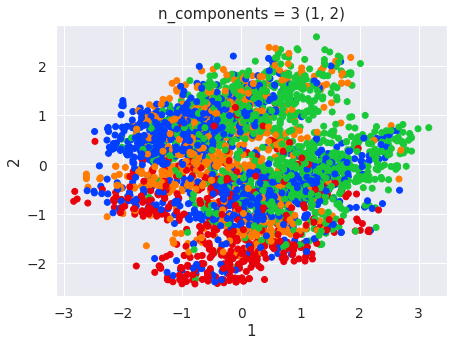

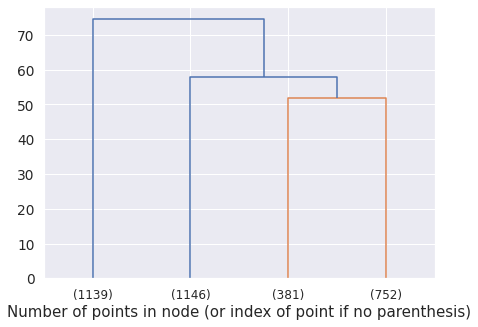

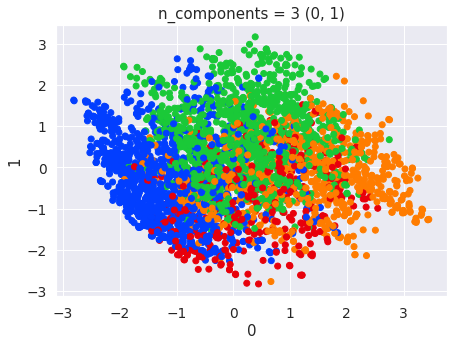

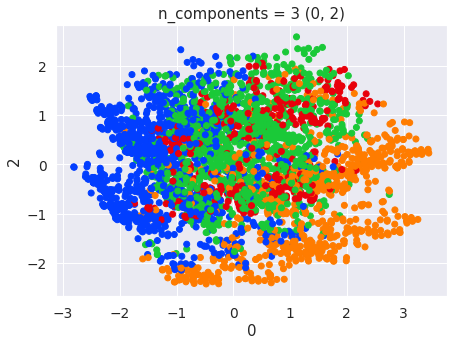

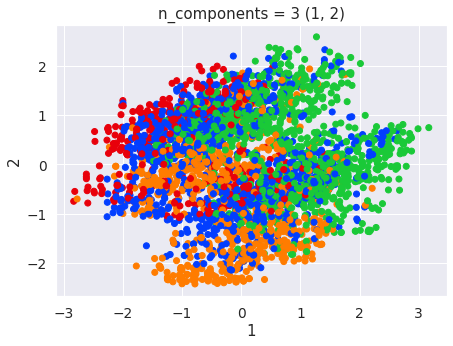

In [44]:
# PCA projection
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_pca)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_pca)

There is a lot of overlap between clusters, at least on this projection.

Categorical:
number of points in each cluster:  0: 1150, 1: 674, 2: 1109, 3: 485
Mixed:
number of points in each cluster:  0: 1139, 1: 752, 2: 1146, 3: 381


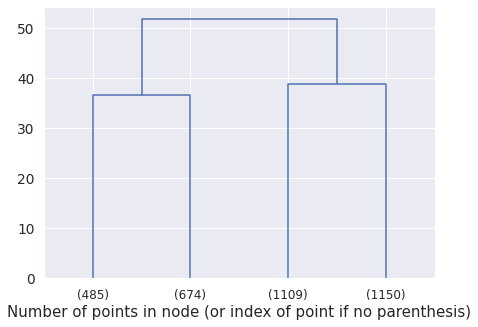

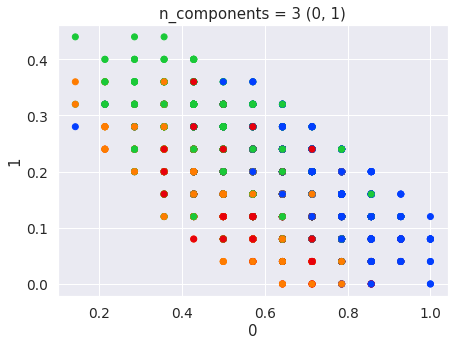

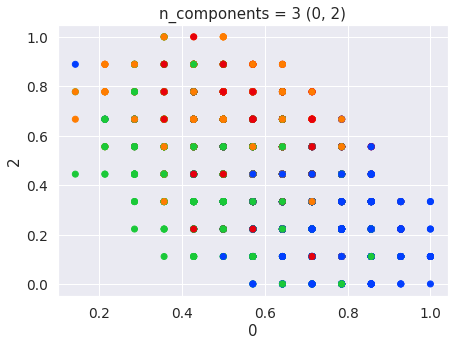

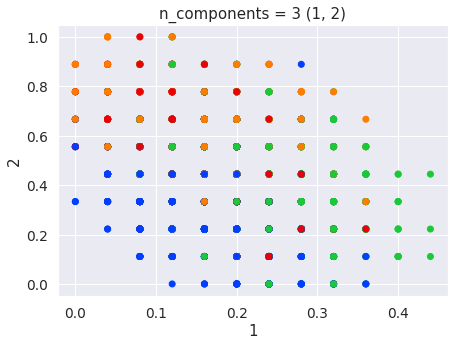

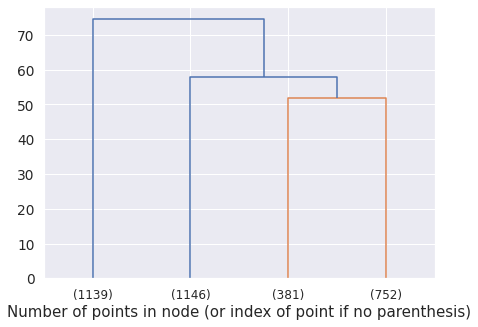

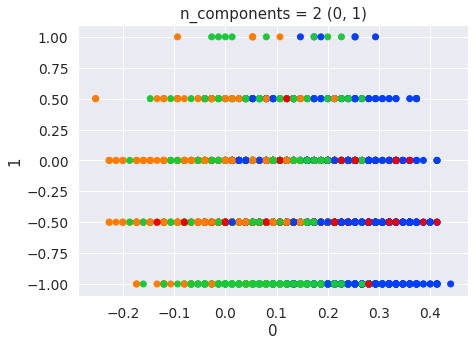

In [45]:
# Feature agglomeration projection
print("Categorical:")
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_fa_allCat)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_fa_mixed)

The clusters do seem somewhat more localized in the feature agglomeration categorical-data projection, but it's unclear to what extent they overlap (multiple points are plotted on top of one another).

##### Cluster lower-dimensional data

If any of the 2D embeddings corresponded to something like the politics-economics axes, we might expect there to be a handful of large clusters and lots of clusters with only a few points (compare w/crosstab).

number of points in each cluster:  0: 1066, 1: 779, 2: 891, 3: 682


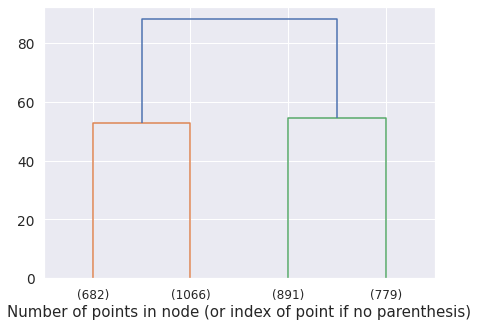

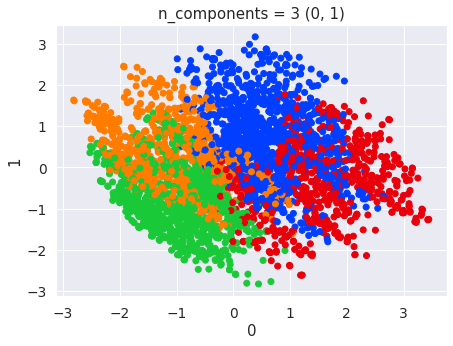

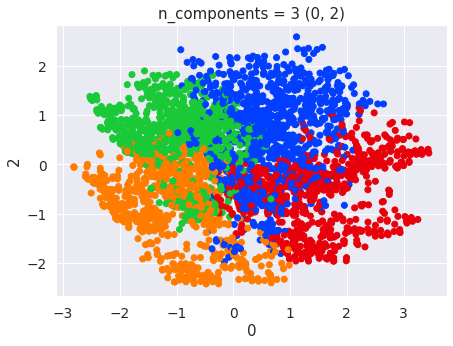

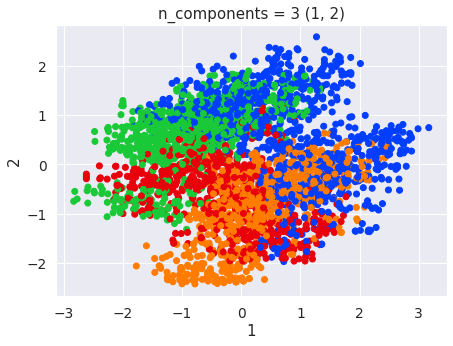

In [46]:
run_agglomerative_clustering(X_pca[:,:3], nClusters)

number of points in each cluster:  0: 833, 1: 947, 2: 807, 3: 831


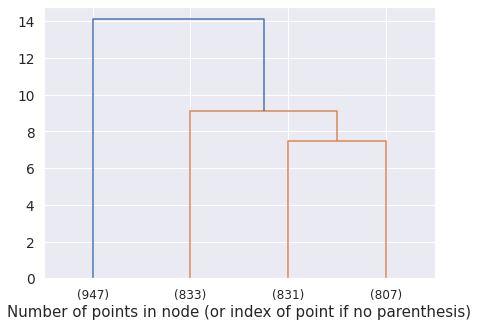

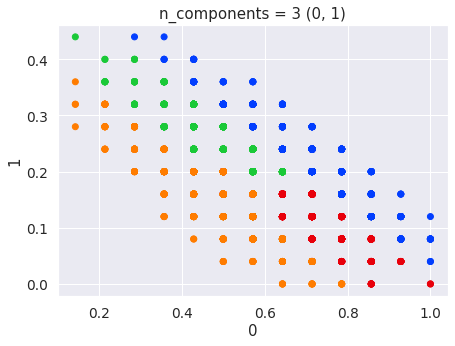

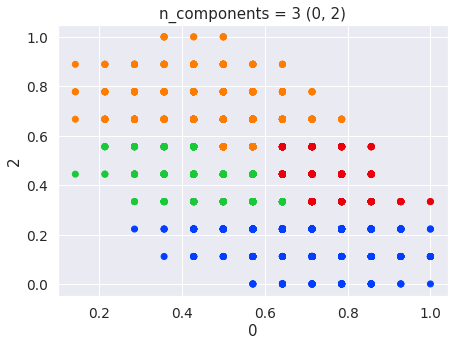

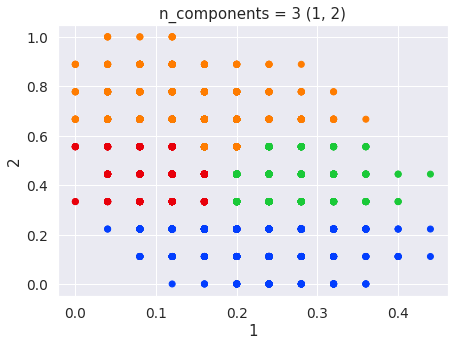

In [47]:
run_agglomerative_clustering(X_fa_allCat, nClusters)

Unfortunately we don't quite observe that, even for other choices of nClusters.